# TD2: Deep learning
<b> Student: Victor Ludvig, November 2023 <b>

In this TD, you must modify this notebook to answer the questions. To do this,

1. Fork this repository
2. Clone your forked repository on your local computer
3. Answer the questions
4. Commit and push regularly

The last commit is due on Sunday, December 1, 11:59 PM. Later commits will not be taken into account.

Install and test PyTorch from  https://pytorch.org/get-started/locally.

> I am using a personal remote jupyter server through ssh tunneling that is running on a pc with two gpus.

In [ ]:
!nvidia-smi

Wed Nov 22 20:09:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8              19W / 420W |    269MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--


To test run the following code

In [2]:
import torch

N, D = 14, 10
x = torch.randn(N, D).type(torch.FloatTensor)
print(x)

from torchvision import models

alexnet = models.alexnet()
print(alexnet)

tensor([[ 0.0178,  1.6891, -2.0583, -1.8950,  0.2852, -1.7336,  1.9278, -0.2358,
         -0.4003, -1.6605],
        [-1.6082, -1.5105, -0.4403,  0.7598, -0.4942,  1.4969, -0.3366, -1.2435,
         -1.7050, -0.7540],
        [ 1.1860, -0.3278, -2.6184, -0.3465,  0.7090, -0.1526, -1.1275,  0.0881,
         -0.2463, -1.2319],
        [ 0.4670, -0.2504, -1.6729,  0.6411,  0.2740, -0.1349,  0.6928, -0.2533,
          1.7291,  1.4626],
        [ 1.8274,  1.7856, -0.0566, -0.7577, -0.5097, -0.6168,  0.4659,  1.5284,
          0.3307,  1.0004],
        [-1.0622, -0.5803,  1.9909,  1.9318, -0.6690,  0.5305, -1.5147, -1.1339,
         -1.2169, -0.0882],
        [-0.5440, -0.7476, -0.7448,  2.0068, -1.6724,  0.2345, -0.0738,  0.6231,
         -0.4004, -0.4285],
        [ 0.2203, -0.1876, -0.7168, -0.0062,  0.3789,  1.5912,  0.4160,  0.6535,
         -2.0524,  0.5317],
        [ 0.1588, -0.7700, -0.0199,  2.4633,  1.4592,  1.0688, -0.5028, -1.3608,
         -1.4286, -0.3072],
        [ 0.3246, -

## Exercise 1: CNN on CIFAR10

The goal is to apply a Convolutional Neural Net (CNN) model on the CIFAR10 image dataset and test the accuracy of the model on the basis of image classification. Compare the Accuracy VS the neural network implemented during TD1.

Have a look at the following documentation to be familiar with PyTorch.

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

You can test if GPU is available on your machine and thus train on it to speed up the process

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import json
from PIL import Image
import pathlib

import warnings
warnings.filterwarnings("ignore")

In [25]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available.  Training on CPU ...")
else:
    print("CUDA is available!  Training on GPU ...")

CUDA is available!  Training on GPU ...


Next we load the CIFAR10 dataset

In [23]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# choose the training and test datasets
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

Files already downloaded and verified
Files already downloaded and verified


CNN definition (this one is an example)

In [4]:
# define the CNN architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(f'x.shape = {x.shape}')
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# create a complete CNN
model = Net()
print(model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Loss function and training using SGD (Stochastic Gradient Descent) optimizer
> I added the running validation loss, to see visually if overfitting occurs. <br>

In [ ]:

criterion = nn.CrossEntropyLoss()  # specify loss function
optimizer = optim.SGD(model.parameters(), lr=0.01)  # specify optimizer

n_epochs = 30  # number of epochs to train the model
train_loss_list = []  # list to store loss to visualize
running_validation_loss = []
valid_loss_min = np.Inf  # track change in validation loss

for epoch in range(n_epochs):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss
        valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_loss_list.append(train_loss)
    running_validation_loss.append(valid_loss)

    # Print training/validation statistics
    print(
        "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
            epoch, train_loss, valid_loss
        )
    )

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, valid_loss
            )
        )
        torch.save(model.state_dict(), "model_cifar.pt")
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 42.195077 	Validation Loss: 37.653781
Validation loss decreased (inf --> 37.653781).  Saving model ...
Epoch: 1 	Training Loss: 34.255484 	Validation Loss: 31.326523
Validation loss decreased (37.653781 --> 31.326523).  Saving model ...
Epoch: 2 	Training Loss: 29.847037 	Validation Loss: 29.189521
Validation loss decreased (31.326523 --> 29.189521).  Saving model ...
Epoch: 3 	Training Loss: 27.616926 	Validation Loss: 27.410780
Validation loss decreased (29.189521 --> 27.410780).  Saving model ...
Epoch: 4 	Training Loss: 26.090010 	Validation Loss: 26.955581
Validation loss decreased (27.410780 --> 26.955581).  Saving model ...
Epoch: 5 	Training Loss: 24.904551 	Validation Loss: 25.293382
Validation loss decreased (26.955581 --> 25.293382).  Saving model ...
Epoch: 6 	Training Loss: 23.761944 	Validation Loss: 24.479699
Validation loss decreased (25.293382 --> 24.479699).  Saving model ...
Epoch: 7 	Training Loss: 22.853249 	Validation Loss: 24.050349
Valid

KeyboardInterrupt: 

Does overfit occur? If so, do an early stopping.
> I did an early stopping around epoch 21.

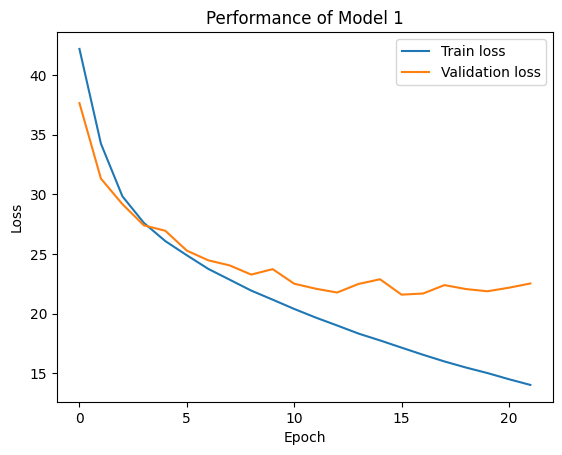

In [ ]:
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.plot([i for i in range(len(running_validation_loss))], running_validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of Model 1")
plt.legend(['Train loss', 'Validation loss'])
plt.show()

Now loading the model with the lowest validation loss value


In [ ]:
model.load_state_dict(torch.load("./model_cifar.pt"))

# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Loss: 21.142969

Test Accuracy of airplane: 63% (635/1000)
Test Accuracy of automobile: 77% (779/1000)
Test Accuracy of  bird: 45% (451/1000)
Test Accuracy of   cat: 52% (528/1000)
Test Accuracy of  deer: 62% (624/1000)
Test Accuracy of   dog: 48% (482/1000)
Test Accuracy of  frog: 72% (726/1000)
Test Accuracy of horse: 70% (708/1000)
Test Accuracy of  ship: 76% (768/1000)
Test Accuracy of truck: 67% (672/1000)

Test Accuracy (Overall): 63% (6373/10000)


Build a new network with the following structure.

- It has 3 convolutional layers of kernel size 3 and padding of 1.
- The first convolutional layer must output 16 channels, the second 32 and the third 64.
- At each convolutional layer output, we apply a ReLU activation then a MaxPool with kernel size of 2.
- Then, three fully connected layers, the first two being followed by a ReLU activation and a dropout whose value you will suggest.
- The first fully connected layer will have an output size of 512.
- The second fully connected layer will have an output size of 64.

Compare the results obtained with this new network to those obtained previously.

> I let the default stride value for the MaxPool2d layer, which is the kernel size (2 here).
> The dimensions of the feature maps output by the the two layers Conv2d/MaxPool2d can be computed:
>> The formula for the Conv2D layer is, with H the height of the feature map (H=W for the Cifar dataset), P the padding, S the stride:
>> $\begin{equation} H' = \frac{H-K+2P}{S} +1 \end{equation}$
>> With our Conv2D layers (P=1, S=1), we see that H' = H
>> The formula is the same for the MaxPool2D Layer, except that there is no padding. With S=2, we see that $H''=\frac{H'}{2}$ 

So, with 3 Conv2D/MaxPool2D layers, it yields: $H'''=\frac{H}{8}=4$ <br>

I set the dropout probability value to 20%. 

In [21]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 4 * 4, 520)
        self.fc2 = nn.Linear(520, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 64 * 4 * 4)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


# create a complete CNN
custom_model = CustomNet()
print(custom_model)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    custom_model.cuda()

CustomNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=520, bias=True)
  (fc2): Linear(in_features=520, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


#### Training of the new version of the neural network

In [26]:
criterion = nn.CrossEntropyLoss()  # specify loss function
optimizer = optim.SGD(custom_model.parameters(), lr=0.01)  # specify optimizer

n_epochs = 30  # number of epochs to train the custom_model
train_loss_list = []  # list to store loss to visualize
valid_loss_min = np.Inf  # track change in validation loss

for epoch in range(n_epochs):
    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the custom_model
    custom_model.train()
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the custom_model
        output = custom_model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to custom_model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the custom_model
    custom_model.eval()
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the custom_model
        output = custom_model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss
        valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_loss_list.append(train_loss)

    # Print training/validation statistics
    print(
        "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
            epoch, train_loss, valid_loss
        )
    )

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(
            "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                valid_loss_min, valid_loss
            )
        )
        torch.save(custom_model.state_dict(), "custom_model2_cifar.pt")
        valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 12.544354 	Validation Loss: 16.590543
Validation loss decreased (inf --> 16.590543).  Saving model ...
Epoch: 1 	Training Loss: 11.670769 	Validation Loss: 16.495301
Validation loss decreased (16.590543 --> 16.495301).  Saving model ...
Epoch: 2 	Training Loss: 10.817358 	Validation Loss: 15.951879
Validation loss decreased (16.495301 --> 15.951879).  Saving model ...
Epoch: 3 	Training Loss: 10.055087 	Validation Loss: 17.362028
Epoch: 4 	Training Loss: 9.229872 	Validation Loss: 17.021478
Epoch: 5 	Training Loss: 8.428759 	Validation Loss: 18.154125
Epoch: 6 	Training Loss: 7.714388 	Validation Loss: 17.146674
Epoch: 7 	Training Loss: 7.027618 	Validation Loss: 17.711753
Epoch: 8 	Training Loss: 6.529375 	Validation Loss: 18.231760
Epoch: 9 	Training Loss: 5.802797 	Validation Loss: 19.035065
Epoch: 10 	Training Loss: 5.315360 	Validation Loss: 19.443799
Epoch: 11 	Training Loss: 4.863536 	Validation Loss: 19.527014
Epoch: 12 	Training Loss: 4.593770 	Validat

KeyboardInterrupt: 

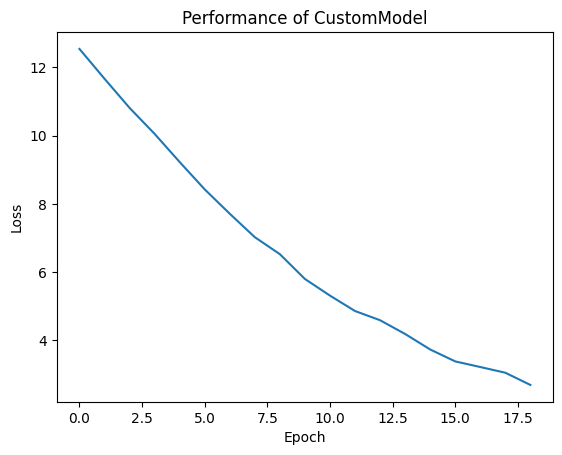

In [27]:
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Performance of CustomModel")
plt.show()

In [9]:
custom_model.load_state_dict(torch.load("./custom_model2_cifar.pt"))

# track test loss
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

custom_model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the custom_model
    output = custom_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (
        np.squeeze(correct_tensor.numpy())
        if not train_on_gpu
        else np.squeeze(correct_tensor.cpu().numpy())
    )
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct),
        np.sum(class_total),
    )
)

Test Loss: 16.366131

Test Accuracy of airplane: 77% (774/1000)
Test Accuracy of automobile: 82% (826/1000)
Test Accuracy of  bird: 67% (678/1000)
Test Accuracy of   cat: 51% (511/1000)
Test Accuracy of  deer: 63% (636/1000)
Test Accuracy of   dog: 59% (596/1000)
Test Accuracy of  frog: 78% (788/1000)
Test Accuracy of horse: 81% (819/1000)
Test Accuracy of  ship: 82% (823/1000)
Test Accuracy of truck: 81% (818/1000)

Test Accuracy (Overall): 72% (7269/10000)


>We observe an increased test accuracy with the modified model (from 63% to 72%). <br>
> I also made an experiment without the dropout layers. The overall accuracy was the same (72%). 

## Exercise 2: Quantization: try to compress the CNN to save space

Quantization doc is available from https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamic
        
The Exercise is to quantize post training the above CNN model. Compare the size reduction and the impact on the classification accuracy 


The size of the model is simply the size of the file.

> <b> Important : Dynamic and static quantization are not supported yet by CUDA, so everything has to run on cpu for quantization. <br>
[https://discuss.pytorch.org/t/does-dynamic-quantization-support-gpu/119231](https://discuss.pytorch.org/t/does-dynamic-quantization-support-gpu/119231) <br>
[https://discuss.pytorch.org/t/dose-static-quantization-support-cuda/85720](https://discuss.pytorch.org/t/dose-static-quantization-support-cuda/85720) <br> <br>

Documentation for quantize_dynamic: [https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html](https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html)

In [9]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("model: ", label, " \t", "Size (KB):", size / 1e3)
    os.remove("temp.p")
    return size

print_size_of_model(custom_model, "fp32")

In [11]:
print(f'First model')
first_model = Net()
first_model.load_state_dict(torch.load("./model_cifar.pt"))
first_model_size = print_size_of_model(first_model, "fp32")
quantized_first_model = torch.quantization.quantize_dynamic(first_model, dtype=torch.qint8)
first_model_quant_size = print_size_of_model(quantized_first_model, "int8")
print(f'Division of the memory for the first model: {first_model_size/first_model_quant_size:.2f}')

print(f'\n\nCustom model')
custom_model = CustomNet()
custom_model.load_state_dict(torch.load("./custom_model2_cifar.pt"))
custom_model_size = print_size_of_model(custom_model, "fp32")
quantized_custom_model = torch.quantization.quantize_dynamic(custom_model, {nn.Linear, nn.Conv2d, nn.MaxPool2d}, dtype=torch.qint8)
custom_model_quant_size = print_size_of_model(quantized_custom_model, "int8")
print(f'Division of the memory for the custom model: {custom_model_size/custom_model_quant_size:.2f}')

First model
model:  fp32  	 Size (KB): 251.278
model:  int8  	 Size (KB): 76.522
Division of the memory for the first model: 3.28


Custom model
model:  fp32  	 Size (KB): 2365.826
model:  int8  	 Size (KB): 668.574
Division of the memory for the custom model: 3.54


The size of the model in kB is divided by more than 3 for both models.

Post training quantization example

For each class, compare the classification test accuracy of the initial model and the quantized model. Also give the overall test accuracy for both models.

#### Compute correct classes for the quantized model
As explained earlier, everything is run on cpu when the model is quantized.

In [12]:
# track test loss
test_loss = 0.0
class_correct_quantized = list(0.0 for i in range(10))
class_total_quantized = list(0.0 for i in range(10))

quantized_custom_model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the quantized_model
    output = quantized_custom_model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = (np.squeeze(correct_tensor.numpy()))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct_quantized[label] += correct[i].item()
        class_total_quantized[label] += 1

# average test loss
test_loss = test_loss / len(test_loader)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total_quantized[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct_quantized[i] / class_total_quantized[i],
                np.sum(class_correct_quantized[i]),
                np.sum(class_total_quantized[i]),
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (classes[i]))

print(
    "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
    % (
        100.0 * np.sum(class_correct_quantized) / np.sum(class_total_quantized),
        np.sum(class_correct_quantized),
        np.sum(class_total_quantized),
    )
)

Test Loss: 16.382165

Test Accuracy of airplane: 77% (773/1000)
Test Accuracy of automobile: 82% (823/1000)
Test Accuracy of  bird: 68% (680/1000)
Test Accuracy of   cat: 50% (507/1000)
Test Accuracy of  deer: 63% (634/1000)
Test Accuracy of   dog: 59% (596/1000)
Test Accuracy of  frog: 78% (784/1000)
Test Accuracy of horse: 81% (817/1000)
Test Accuracy of  ship: 82% (823/1000)
Test Accuracy of truck: 82% (820/1000)

Test Accuracy (Overall): 72% (7257/10000)


> We see that the overall accuracy is the same for the quantized model. <br>
There are only 5 more wronlgy classified classes for the quantized model, out of 10.000 instances.
<br>

Now I will plot the class accuracy of both models.

In [14]:
test_accuracy_classes = [c_correct/c_total for (c_correct, c_total) in zip(class_correct, class_total)]
test_accuracy_classes_quantized = [c_correct/c_total for (c_correct, c_total) in zip(class_correct_quantized, class_total_quantized)]

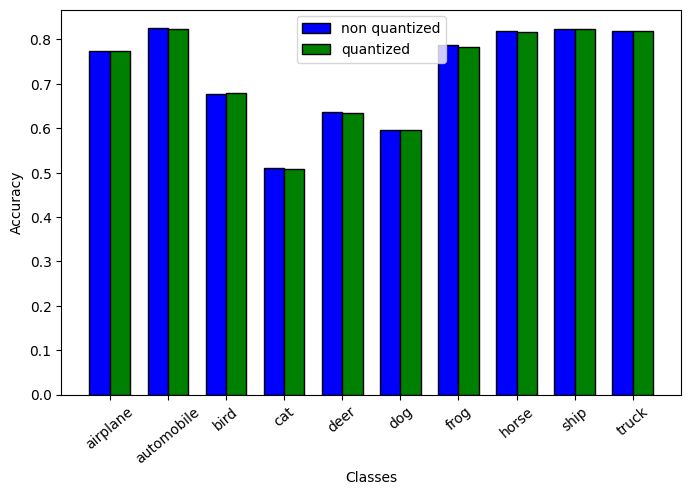

In [42]:
bar_width = 0.35
indexes = np.asarray([i for i in range(1,11)]) 
plt.figure(figsize=(8,5))
plt.bar(indexes, test_accuracy_classes, width=bar_width, color='blue', edgecolor='black')
plt.bar(indexes+bar_width, test_accuracy_classes_quantized, width=bar_width, color='green', edgecolor='black')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.xticks(indexes + bar_width / 2, classes, rotation=40) 
plt.legend(['non quantized', 'quantized'])

> We can see that the class accuracy are similar, even better with the quantized model for trucks.

Try training aware quantization to mitigate the impact on the accuracy (doc available here https://pytorch.org/docs/stable/quantization.html#torch.quantization.quantize_dynamic)
> Since I trained on gpu and quantization is not available on gpu, I didn't do the quantization aware training. 
<br> I will do it in the 4th part, since training is very fast for transfer-learning when most of the layers are frozen, and it can be done with the cpu.

## Exercise 3: working with pre-trained models.

PyTorch offers several pre-trained models https://pytorch.org/vision/0.8/models.html        
We will use ResNet50 trained on ImageNet dataset (https://www.image-net.org/index.php). Use the following code with the files `imagenet-simple-labels.json` that contains the imagenet labels and the image dog.png that we will use as test.


Predicted class is: Golden Retriever


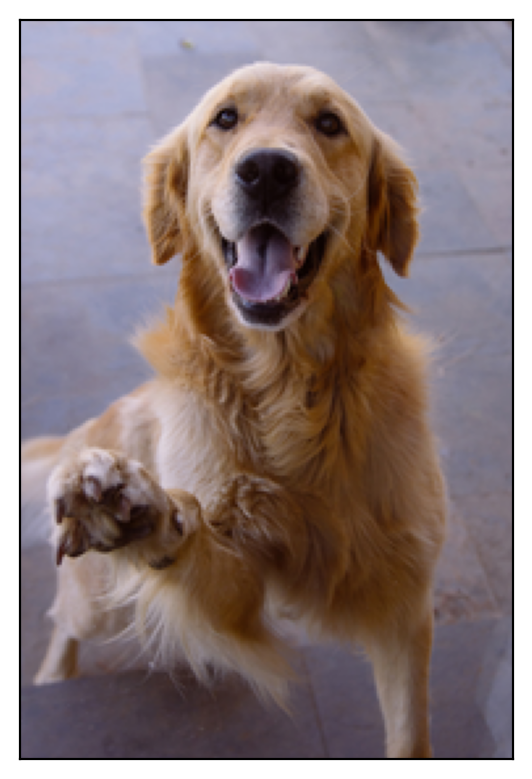

In [4]:
# Choose an image to pass through the model
test_image = "dog.png"

# Configure matplotlib for pretty inline plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare the labels
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

# First prepare the transformations: resize the image to what the model was trained on and convert it to a tensor
data_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
# Load the image

image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

# Now apply the transformation, expand the batch dimension, and send the image to the GPU
image = data_transform(image).unsqueeze(0).cuda()
# image = data_transform(image).unsqueeze(0)

# Download the model if it's not there already. It will take a bit on the first run, after that it's fast
resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# Send the resnet_model to the GPU
resnet_model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
resnet_model.eval()

# Get the 1000-dimensional model output
out = resnet_model(image)
# Find the predicted class
print("Predicted class is: {}".format(labels[out.argmax()]))

Experiments:

Study the code and the results obtained. Possibly add other images downloaded from the internet.
> I added 3 other images from the internet.

What is the size of the model? Quantize it and then check if the model is still able to correctly classify the other images.

Experiment with other pre-trained CNN models.

#### Adding the 3 images from the Internet

list_predictions = ['tabby cat', 'Golden Retriever', 'lynx', 'African bush elephant']


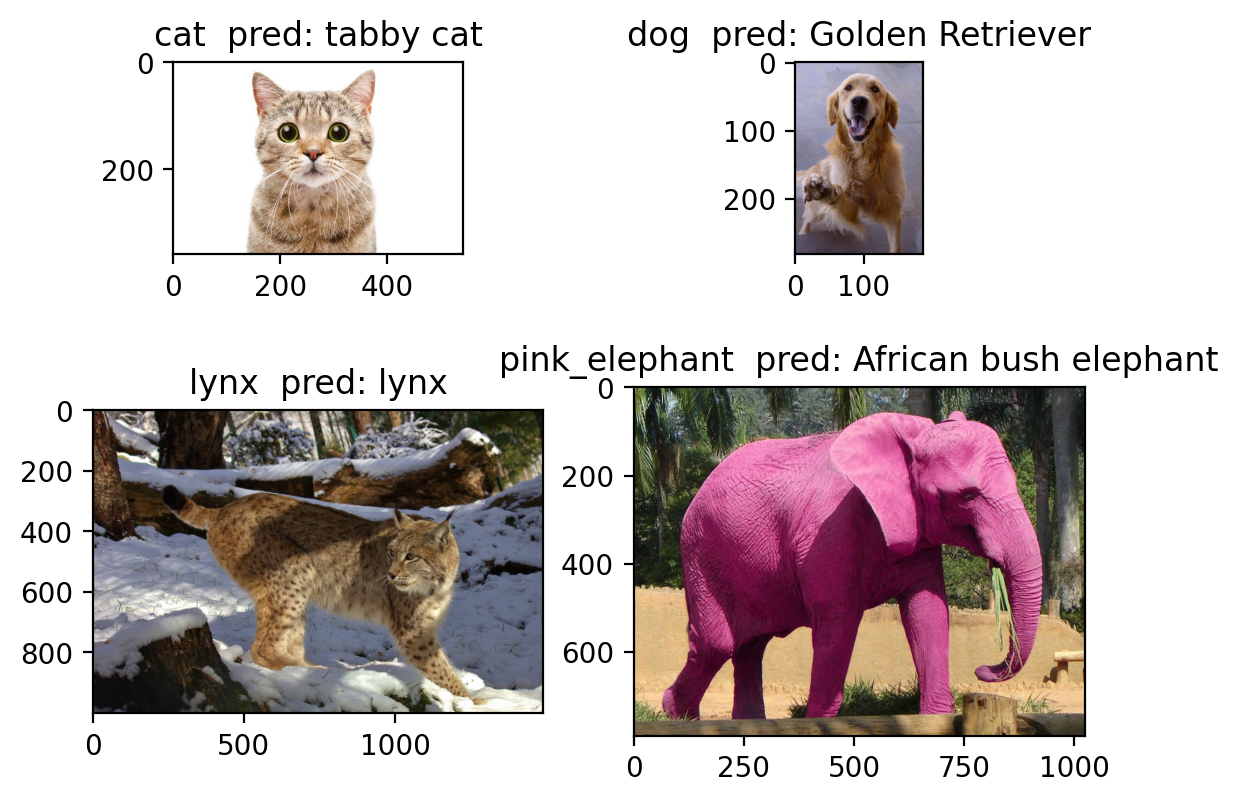

In [5]:
def predictions(model, cuda=True):
    list_name_images = [pathlib.Path('cat.jpg'), pathlib.Path('dog.png'), pathlib.Path('lynx.jpg'), pathlib.Path('pink_elephant.jpg')]
    if cuda:
        list_predictions = [labels[model(data_transform(Image.open(x)).unsqueeze(0).cuda()).argmax()] for x in list_name_images]
    else:
        list_predictions = [labels[model(data_transform(Image.open(x)).unsqueeze(0)).argmax()] for x in list_name_images]
    print(f'list_predictions = {list_predictions}')

    fig, axs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [2, 5]})

    axs[0, 0].imshow(Image.open(list_name_images[0]))
    axs[0, 0].set_title(list_name_images[0].stem + f'  pred: {list_predictions[0]}')

    axs[0, 1].imshow(Image.open(list_name_images[1]))
    axs[0, 1].set_title(list_name_images[1].stem + f'  pred: {list_predictions[1]}')

    axs[1, 0].imshow(Image.open(list_name_images[2]))
    axs[1, 0].set_title(list_name_images[2].stem + f'  pred: {list_predictions[2]}')

    axs[1, 1].imshow(Image.open(list_name_images[3]))
    axs[1, 1].set_title(list_name_images[3].stem + f'  pred: {list_predictions[3]}')
predictions(resnet_model)

Results are pretty good, I don't know if the first cat is a tabby cat but the lynx is well predicted. <br>
Obviously, the ImageNet datast on which the ResNet50 model was trained doesn't contain pink elephants!

##### Experiment with other models
I experiment with AlexNet, the first Deep CNN, potentially not as good as ResNet.

list_predictions = ['Egyptian Mau', 'Golden Retriever', 'lynx', 'tusker']


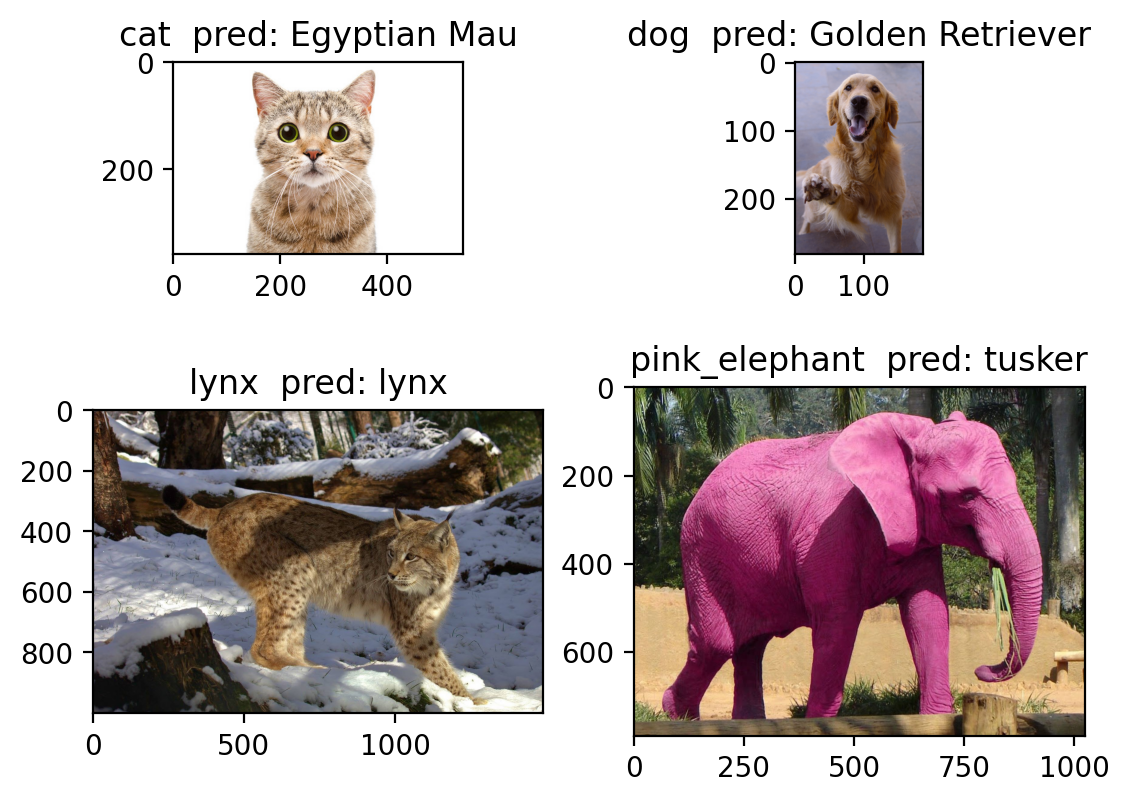

In [6]:
alexnet_model = models.alexnet(weights=models.AlexNet_Weights)
alexnet_model.cuda()
alexnet_model.eval()

predictions(alexnet_model)

Interestingly, the first cat is now an Egyptian Mau. My family actually own an Egyptian Mau, there are grey, which doesn't seem not the case of this cat. However, it is still a cat. <br>
The elephant is now a tusker, which is more general than an elephant, but still true. Overall AlexNet is pretty good despite some innacuracies. <br><br>
I now experiement with a Vision Transformer, which I studied during an internship. They are at the basis of the foundation Segment Anything Model for image segmentation, published April 2023, that I studied and used during the internship. Results of SAM were astounding, and I except excellent results on our 4 images.

list_predictions = ['Egyptian Mau', 'Golden Retriever', 'lynx', 'African bush elephant']


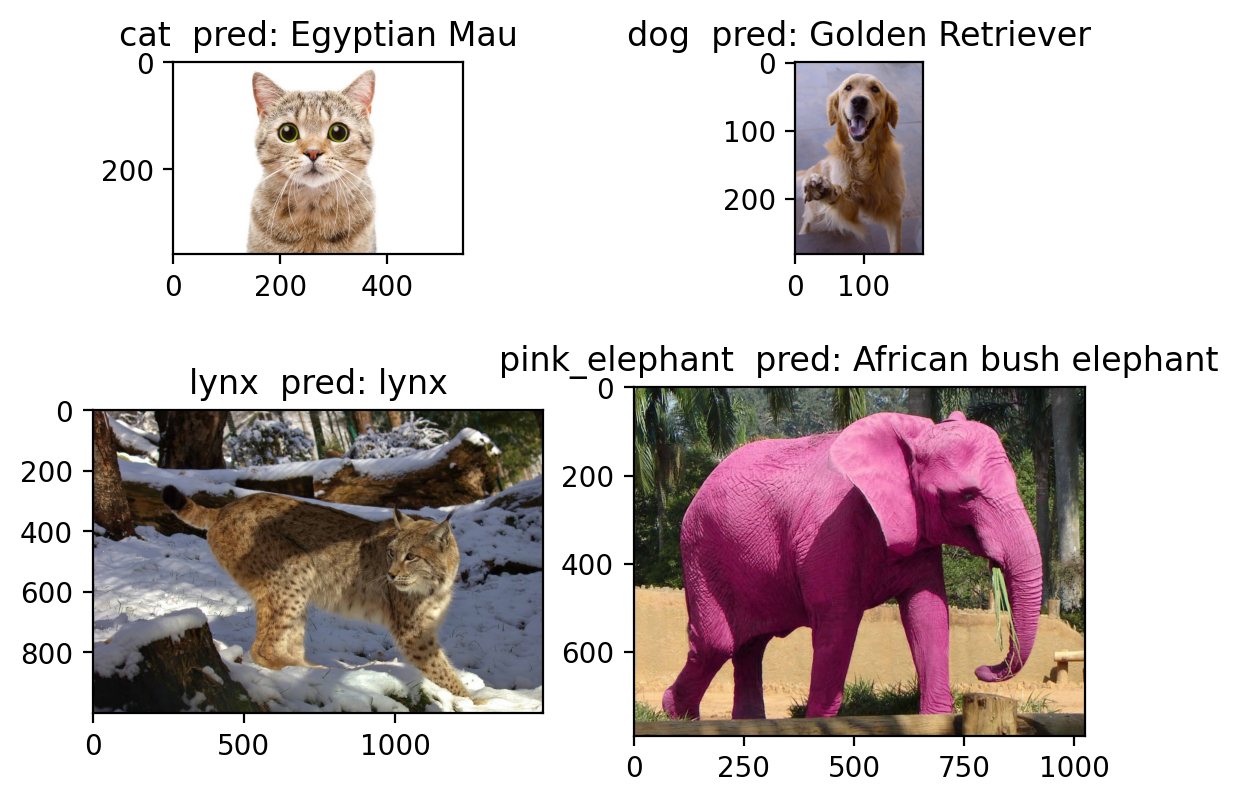

In [7]:
vitb16_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vitb16_model.cuda()
vitb16_model.eval()

predictions(vitb16_model)

We get once again the Egyptian Mau, which means that this prediction of the AlexNet model was accurate. <br>
It seems that this Vision Transformer is most accurate of the 3 models tested.

#### Quantization
> We will use the models.quantization library for the quantized resnet. <br>
> It offers a special kind of resnet with special quantizable layers added so that the model can be quantized. <br>
> We will directly load the quantized version with the argument quantize=True.

In [10]:
resnet_size = print_size_of_model(resnet_model, "fp32")
quantized_resnet = models.quantization.resnet50(weights=models.quantization.ResNet50_QuantizedWeights.IMAGENET1K_FBGEMM_V1, quantize=True)
quantized_resnet_size = print_size_of_model(quantized_resnet, "int8")
print(f'Division of the memory for the resnet model: {resnet_size/quantized_resnet_size:.2f}')

model:  fp32  	 Size (KB): 102527.718
model:  int8  	 Size (KB): 26150.056
Division of the memory for the resnet model: 3.92


> The quantization process divided the memory of the model by almost 4. <br>

#### Predictions with the quantized model

list_predictions = ['tabby cat', 'Golden Retriever', 'lynx', 'African bush elephant']


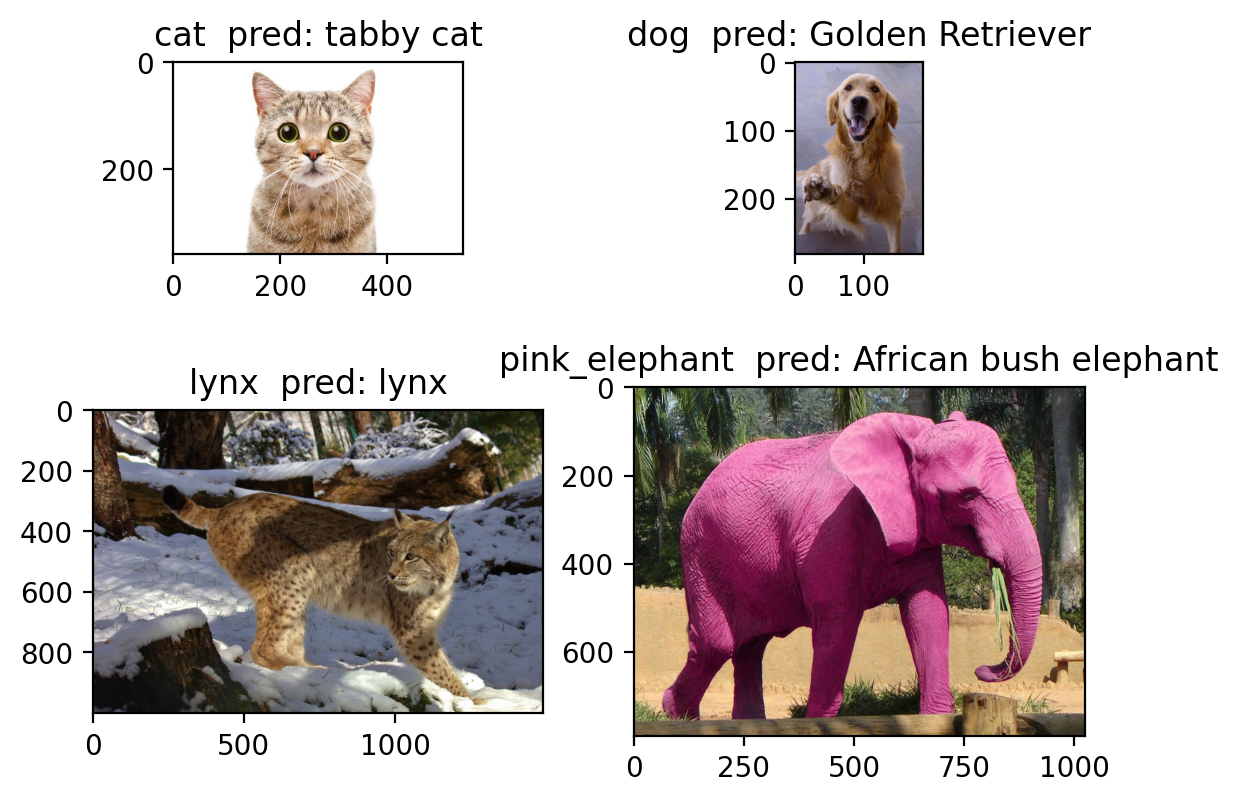

In [12]:
predictions(quantized_resnet, cuda=False)

> Results are the same with the quantized resnet

## Exercise 4: Transfer Learning
    
    
For this work, we will use a pre-trained model (ResNet18) as a descriptor extractor and will refine the classification by training only the last fully connected layer of the network. Thus, the output layer of the pre-trained network will be replaced by a layer adapted to the new classes to be recognized which will be in our case ants and bees.
Download and unzip in your working directory the dataset available at the address :
    
https://download.pytorch.org/tutorial/hymenoptera_data.zip
    
Execute the following code in order to display some images of the dataset.

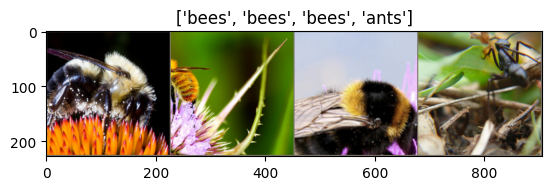

In [24]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "hymenoptera_data/hymenoptera_data"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=0
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Now, execute the following code which uses a pre-trained model ResNet18 having replaced the output layer for the ants/bees classification and performs the model training by only changing the weights of this output layer.

> I added the variable batch_size so that we can use it later when testing the model.

In [19]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms


batch_size = 4
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(
                224
            ),  # ImageNet models were trained on 224x224 images
            transforms.RandomHorizontalFlip(),  # flip horizontally 50% of the time - increases train set variability
            transforms.ToTensor(),  # convert it to a PyTorch tensor
            transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
            ),  # ImageNet models expect this norm
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    'test': transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
}

data_dir = "hymenoptera_data/hymenoptera_data/"
# Create train and validation datasets and loaders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val", 'test']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in ["train", "val", 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", 'test']}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Helper function for displaying images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Un-normalize the images
    inp = std * inp + mean
    # Clip just in case
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])
# training


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    print(f'training model')
    since = time.time()

    print(f'making deepcopy...')
    best_model_wts = copy.deepcopy(model.state_dict())
    print(f'deep copy made!')
    best_acc = 0.0

    epoch_time = []  # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if train_on_gpu:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:4f}".format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time


# Download a pre-trained ResNet18 model and freeze its weights
model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# Send the model to the GPU
if torch.cuda.is_available(): train_on_gpu = True
model = model.to(device)
# Set the loss function
criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv.step()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, epoch_time = train_model(
    model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10
)

training model
making deepcopy...
deep copy made!
Epoch 1/10
----------
train Loss: 0.5520 Acc: 0.7254
val Loss: 1.0184 Acc: 0.6013

Epoch 2/10
----------
train Loss: 0.5912 Acc: 0.7336
val Loss: 0.1940 Acc: 0.9346

Epoch 3/10
----------
train Loss: 0.4108 Acc: 0.8238
val Loss: 0.2173 Acc: 0.9216

Epoch 4/10
----------
train Loss: 0.3564 Acc: 0.8443
val Loss: 0.2037 Acc: 0.9281

Epoch 5/10
----------
train Loss: 0.4317 Acc: 0.8115
val Loss: 0.3548 Acc: 0.8627

Epoch 6/10
----------
train Loss: 0.4938 Acc: 0.7828
val Loss: 0.3136 Acc: 0.8954

Epoch 7/10
----------
train Loss: 0.4282 Acc: 0.8320
val Loss: 0.1930 Acc: 0.9216

Epoch 8/10
----------
train Loss: 0.3752 Acc: 0.8238
val Loss: 0.1621 Acc: 0.9477

Epoch 9/10
----------
train Loss: 0.3944 Acc: 0.8156
val Loss: 0.2451 Acc: 0.8954

Epoch 10/10
----------
train Loss: 0.4045 Acc: 0.8156
val Loss: 0.1690 Acc: 0.9477

Training complete in 0m 5s
Best val Acc: 0.947712


Experiments:
Study the code and the results obtained.

Modify the code and add an "eval_model" function to allow
the evaluation of the model on a test set (different from the learning and validation sets used during the learning phase). Study the results obtained.

Now modify the code to replace the current classification layer with a set of two layers using a "relu" activation function for the middle layer, and the "dropout" mechanism for both layers. Renew the experiments and study the results obtained.

Apply ther quantization (post and quantization aware) and evaluate impact on model size and accuracy.

#### Comments on the results obtained
> The train loss is already above 50% (70%) after only one epoch: the model is pre-trained and is already capable to detect special feature maps in the input images, so the learning of the last fully connected layer is very fast.

#### Modification of the code
>First a new test is created

In [4]:
dataset_sizes

{'train': 244, 'val': 153, 'test': 160}

> There are 70 ants and 83 bees in the validation dataset, hence I created a test set with roughly the same size: 80 ants and 80 bees. <br>
> The images were taken from this website: [https://images.cv](https://images.cv) <br>
>> Bee dataset: [https://images.cv/dataset/bee-image-classification-dataset](https://images.cv/dataset/bee-image-classification-dataset) <br>
>> Ant dataset: [https://images.cv/dataset/ant-image-classification-dataset](https://images.cv/dataset/ant-image-classification-dataset) 

>Then the code is modified: a transformation is defined for the test folder. It is similar to the other transformtions, except here we don't Center Crop the images since we don't want to do data augmentation. Hence we resize directly to 224x224.

> Eval function <br>
> I adapted the code proposed part II

In [5]:
def eval_model(model):
    test_loss = 0.0
    class_correct = list(0.0 for i in range(10))
    class_total = list(0.0 for i in range(10))
    for data, labels in dataloaders['test']:
        if train_on_gpu:
            data, labels = data.cuda(), labels.cuda()
        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = (
            np.squeeze(correct_tensor.numpy())
            if not train_on_gpu
            else np.squeeze(correct_tensor.cpu().numpy())
        )
        for i in range(batch_size):
            class_correct[labels[i]] += correct[i].item()
            class_total[labels[i]] += 1

    # average test loss
    test_loss = test_loss / len(dataloaders['test'])
    print("Test Loss: {:.6f}\n".format(test_loss))

    for i in range(len(class_names)):
        if class_total[i] > 0:
            print(
                "Test Accuracy of %5s: %2d%% (%2d/%2d)"
                % (
                    class_names[i],
                    100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]),
                    np.sum(class_total[i]),
                )
            )
        else:
            print("Test Accuracy of %5s: N/A (no training examples)" % (class_names[i]))

    print(
        "\nTest Accuracy (Overall): %2d%% (%2d/%2d)"
        % (
            100.0 * np.sum(class_correct) / np.sum(class_total),
            np.sum(class_correct),
            np.sum(class_total),
        )
    )
eval_model(model)

Test Loss: 1.187997

Test Accuracy of  ants: 91% (73/80)
Test Accuracy of  bees: 81% (65/80)

Test Accuracy (Overall): 86% (138/160)


> Results are pretty good for ants (90% accuracy), but the model is underperforming for bees. It probably stems for the bee dataset used, which contains cartoon images on which the model wasn't trained.

> See my Note in Evaluation ResNet18 part for changing results throughout learning sessions.

#### Modification of the classification layer of the pretrained ResNet18
> I set the Dropout value to 0.3, a bit higher than for exercice 1, but not too high because we are training on a small dataset. <br>
The size of the input to the new_layer is num_ftrs=512, hence I chose 128 for the size of the middle layer. <br>
The number of epochs was increased from 10 to 20 because this new version is more complex and more parameters have to be optimised.

In [6]:
resnet18_custom = torchvision.models.resnet18(pretrained=True)
for param in resnet18_custom.parameters():
    param.requires_grad = False

num_ftrs = resnet18_custom.fc.in_features

# Define the new layers
new_layers = [
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),        
    nn.Dropout(0.3),          
    nn.Linear(128, len(class_names))  
]

# Replace the final classification layer with the new layers
resnet18_custom.fc = nn.Sequential(*new_layers)

criterion = nn.CrossEntropyLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.SGD(resnet18_custom.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

resnet18_custom = resnet18_custom.to(device)
# resnet18_custom
resnet18_custom, epoch_time = train_model(
    resnet18_custom, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=20
)

training model
making deepcopy...
deep copy made!
Epoch 1/20
----------


/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hacklexander/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 0.6685 Acc: 0.5738
val Loss: 0.5348 Acc: 0.6863

Epoch 2/20
----------
train Loss: 0.6372 Acc: 0.6352
val Loss: 0.4368 Acc: 0.7908

Epoch 3/20
----------
train Loss: 0.5987 Acc: 0.6475
val Loss: 0.3222 Acc: 0.9216

Epoch 4/20
----------
train Loss: 0.5245 Acc: 0.6926
val Loss: 0.2991 Acc: 0.9150

Epoch 5/20
----------
train Loss: 0.4853 Acc: 0.7910
val Loss: 0.2265 Acc: 0.9412

Epoch 6/20
----------
train Loss: 0.4274 Acc: 0.7992
val Loss: 0.2170 Acc: 0.9477

Epoch 7/20
----------
train Loss: 0.4159 Acc: 0.8279
val Loss: 0.2160 Acc: 0.9477

Epoch 8/20
----------
train Loss: 0.3610 Acc: 0.8443
val Loss: 0.2075 Acc: 0.9542

Epoch 9/20
----------
train Loss: 0.4532 Acc: 0.7746
val Loss: 0.2221 Acc: 0.9412

Epoch 10/20
----------
train Loss: 0.4177 Acc: 0.8074
val Loss: 0.2162 Acc: 0.9412

Epoch 11/20
----------
train Loss: 0.4282 Acc: 0.7910
val Loss: 0.2029 Acc: 0.9412

Epoch 12/20
----------
train Loss: 0.3672 Acc: 0.8484
val Loss: 0.2032 Acc: 0.9412

Epoch 13/20
----------


> We observe a slight increase in the validation accuracy, from 0.96 to 0.967.
> Overall the training metrics are similar, except that the initial accuracy (after 1 epoch) is lower for the more complex model: more paramters have to be optimised and cannot be optimised in just 1 epoch. <br>
> Note: I rerun the cell and other validation accuracies, ranging from 0.94 to 0.967

#### Evaluation of the custom resnet18

In [7]:
eval_model(resnet18_custom)

Test Loss: 1.573843

Test Accuracy of  ants: 88% (71/80)
Test Accuracy of  bees: 71% (57/80)

Test Accuracy (Overall): 80% (128/160)


> Interestingly, the bee classification accuracy is higher this time, from 72% to 85%. <br>
> This custom model generalizes better on the test set. <br>
> The test accuracy of ants is slightly lower (from 90% to 82%), but the overall accuracy is higher (from 81% to 85%). 


> Note: This might only due to the randomnes of training ; the optimisation of the weights depends on the order of the training instances, and the argument shuffle=True in the DataLoader instanciation implies that this order varies throughout training sessions. Hence, we could potentially get similar results with the non-customized resnet model, depending of the random order of the training instances. In fact results changes throughout learning sessions.

#### Quantization
> I am using the following tutorial to do this part: [https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html) <br>


> First the pre-trained model is loaded from the quantization module.

In [8]:
resnet18q = models.quantization.resnet18(weights=models.quantization.ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1, progress=True, quantize=True)
num_ftrs = resnet18q.fc.in_features

/home/hacklexander/.local/lib/python3.10/site-packages/torch/_utils.py:361: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  scales = torch.tensor(scales, dtype=torch.double, device=storage.device)


> Then the feature extractor of the ResNet18 model is extracted. <br>
> This part is not trainable. <br>
> A new trainable head is added after the feature extractor. <br>

In [9]:
def create_combined_model(resnet18q):
  # Step 1. Isolate the feature extractor.
  resnet18q_features = nn.Sequential(
    resnet18q.quant,  # Quantize the input
    resnet18q.conv1,
    resnet18q.bn1,
    resnet18q.relu,
    resnet18q.maxpool,
    resnet18q.layer1,
    resnet18q.layer2,
    resnet18q.layer3,
    resnet18q.layer4,
    resnet18q.avgpool,
    resnet18q.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    resnet18q_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [14]:
new_resnet18 = create_combined_model(resnet18q)
new_resnet18 = new_resnet18.to('cpu')
size_resnet18 = print_size_of_model(model)
size_new = print_size_of_model(new_resnet18)
print(f'Division of the memory for the resnet model: {size_resnet18/size_new:.2f}')

model:    	 Size (KB): 44782.148
model:    	 Size (KB): 11304.234
Division of the memory for the resnet model: 3.96


In [15]:
train_on_gpu = False
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(new_resnet18.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
new_resnet18, epoch_time = train_model(
    new_resnet18, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10
)

training model
making deepcopy...
deep copy made!
Epoch 1/10
----------
train Loss: 0.6965 Acc: 0.7582
val Loss: 0.1293 Acc: 0.9542

Epoch 2/10
----------
train Loss: 0.3903 Acc: 0.8484
val Loss: 0.2352 Acc: 0.9085

Epoch 3/10
----------
train Loss: 0.2928 Acc: 0.8975
val Loss: 0.1618 Acc: 0.9608

Epoch 4/10
----------
train Loss: 0.2971 Acc: 0.8893
val Loss: 0.1898 Acc: 0.9477

Epoch 5/10
----------
train Loss: 0.1975 Acc: 0.9180
val Loss: 0.2167 Acc: 0.9346

Epoch 6/10
----------
train Loss: 0.3166 Acc: 0.9139
val Loss: 0.1463 Acc: 0.9608

Epoch 7/10
----------
train Loss: 0.2794 Acc: 0.9098
val Loss: 0.1485 Acc: 0.9673

Epoch 8/10
----------
train Loss: 0.2090 Acc: 0.9139
val Loss: 0.1523 Acc: 0.9608

Epoch 9/10
----------
train Loss: 0.1850 Acc: 0.9262
val Loss: 0.1626 Acc: 0.9608

Epoch 10/10
----------
train Loss: 0.1999 Acc: 0.9262
val Loss: 0.1477 Acc: 0.9673

Training complete in 0m 20s
Best val Acc: 0.967320


> We observe an increased accuracy compared to the non quantized model: fom 0.96 to 0.973

In [18]:
eval_model(new_resnet18)

Test Loss: 1.831579

Test Accuracy of  ants: 91% (73/80)
Test Accuracy of  bees: 71% (57/80)

Test Accuracy (Overall): 81% (130/160)


> We observe a decrease in the training accuracy, from 86% to 81%. <br>
> However, resuts are still pretty good.

## Optional
    
Try this at home!! 


Pytorch offers a framework to export a given CNN to your selfphone (either android or iOS). Have a look at the tutorial https://pytorch.org/mobile/home/

The Exercise consists in deploying the CNN of Exercise 4 in your phone and then test it on live.



## Author

Alberto BOSIO - Ph. D.